In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dropout, Dense, Activation, Conv1D, GlobalMaxPooling1D, MaxPooling1D, concatenate, Flatten, Reshape
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras import Input

import datetime
import os

Using TensorFlow backend.


In [13]:
## 하이퍼 파라메터

delta = 1e-7
seq_len = 7
test_date = 304

level_1 = 30
level_2 = 80
level_3 = 150

num_level = 4

pm_target = level_3 * 2
wind_speed_target = 14 # 강한 바람
wind_direction_target = 360 # 16방위

year = 365
train_cut = year * 9 + 1 -30

test_cut = -test_date

In [14]:
## 데이터 로드
data = pd.read_csv('dataset/PM_2.5_dataset_09_19.csv', index_col=0)
data.head()

,PM Seoul,PM Beijing,avg temprature,avg humidity,avg wind speed seoul,max wind direction seoul,avg wind speed back,max wind direction back
date,,,,,,,,
2009-01-01,43.739130,181.083875,-5.8,45.8,2.3,290.0,4.5,320
2009-01-02,45.750000,168.780998,-2.8,51.5,1.6,290.0,4.2,320
2009-01-03,46.833333,177.560185,-1.0,48.3,1.8,20.0,2.8,320
2009-01-04,40.083333,169.828704,0.4,44.3,1.9,290.0,3.1,290
2009-01-05,58.541667,140.598765,-1.6,53.1,2.2,290.0,5.0,290


In [15]:
## 초기 데이터 입력

pm_seoul_data = data['PM Seoul'].values
pm_beijing_data = data['PM Beijing'].values
wind_speed_seoul_data = data['avg wind speed seoul'].values
wind_direction_seoul_data = data['max wind direction seoul'].values
wind_speed_back_data = data['avg wind speed back'].values
wind_direction_back_data = data['max wind direction back'].values

In [16]:
## 시계열 함수
def make_sequential(data):
    for i in range(len(data)):
        if data[i] == 0:
            data[i] = data[i]+delta
        
    sequence_length = seq_len + 1
    
    temp_data = []
    for index in range((len(data) - sequence_length)+1):
        temp_data.append(data[index: index + sequence_length])
        
    return np.array(temp_data)

In [17]:
def pm_norm_window(data):
    norm_data = []
    
    for i in range(len(data)):
        norm_data.append(data[i] / pm_target)
        
    return norm_data

In [18]:
def wind_speed_norm_window(data):
    norm_data = []
    
    for i in range(len(data)):
        norm_data.append(data[i] / wind_speed_target)
        
    return norm_data

In [19]:
def wind_direction_norm_window(data):
    norm_data = []
    
    for i in range(len(data)):
        norm_data.append(data[i] / wind_direction_target)
        
    return norm_data

In [20]:
norm_pm_seoul = make_sequential(pm_norm_window(pm_seoul_data))
norm_pm_beijing = make_sequential(pm_norm_window(pm_beijing_data))
norm_wind_speed_seoul = make_sequential(wind_speed_norm_window(wind_speed_seoul_data))
norm_wind_speed_back = make_sequential(wind_speed_norm_window(wind_speed_back_data))
norm_wind_direction_seoul = make_sequential(wind_direction_norm_window(wind_direction_seoul_data))
norm_wind_direction_back = make_sequential(wind_direction_norm_window(wind_direction_back_data))

In [23]:
## 병합함수

def marge_data(a, b, c, d, e, f):
    marged_data = []
    marge = []
    
    for a_index, b_index, c_index, d_index, e_index, f_index in zip(a, b, c, d, e, f):
        for i in range(len(a_index)):
            marge.append(a_index[i])
            marge.append(b_index[i])
            #marge.append(c_index[i])
            #marge.append(d_index[i])
            #marge.append(e_index[i])
            #marge.append(f_index[i])
            
        for i in range(1):
            marge.pop()
        
        marged_data.append(marge)
        marge = []
    
    return np.array(marged_data)

norm_result = marge_data(norm_pm_seoul, norm_pm_beijing, norm_wind_speed_seoul, 
                         norm_wind_speed_seoul, norm_wind_direction_seoul, norm_wind_direction_back)
print(norm_result[0])

[0.13971014 0.60361292 0.17888889 0.56260333 0.13736111 0.59186728
 0.13125    0.56609568 0.13680556 0.46866255 0.12263889 0.4704321
 0.22527778 0.50746847 0.18597222]


In [24]:

train = norm_result[:train_cut, :]
np.random.shuffle(train)

valid = norm_result[train_cut:test_cut, :]
#np.random.shuffle(valid)

test = norm_result[test_cut:, :]

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:,-1]
y_train = np.reshape(y_train, (y_train.shape[0], 1))

x_valid = valid[:, :-1]
x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))
y_valid = valid[:,-1]
y_valid = np.reshape(y_valid, (y_valid.shape[0], 1))

x_test = test[:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = test[:,-1]
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(x_train.shape, x_valid.shape, x_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(3256, 14, 1) (389, 14, 1) (304, 14, 1)
(3256, 1) (389, 1) (304, 1)


In [ ]:
### 모델 체크포인터 롤백
MODEL_SAVE_FOLBER_PATH = './model/checkpoint_archi_5/'
if not os.path.exists(MODEL_SAVE_FOLBER_PATH):
    os.mkdir(MODEL_SAVE_FOLBER_PATH)
    
model_path = MODEL_SAVE_FOLBER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'

# 체크포인트 생성 코드
cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',verbose=1, save_best_only=True, mode='auto')

### 학습 모델 로드

model = load_model('model/pm_prediction_model_achi_6.h5')

In [25]:
### VCRNN 모델 설계
model = Sequential()


model.add(Conv1D(32, 2, activation='linear',strides=2, input_shape=(seq_len*2,1)))
model.add(Conv1D(64, 1, activation='linear',strides=1))

# model.add(Conv1D(60, 3, activation='relu',strides=1, padding="same"))
for i in range (2):
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=False))3
model.add(Dropout(0.5))

model.add(Dense(1, activation='linear'))

model.summary()

W1114 10:21:48.080059 11360 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1114 10:21:48.280986 11360 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1114 10:21:48.337967 11360 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1114 10:21:48.910783 11360 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1114 10:21:48.916782 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 7, 32)             96        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 7, 64)             2112      
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 128)            98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 128)            131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 128)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
__________

In [ ]:
## 콜백 리스트 - 정해진 에폭동안 모니터링 지표가 향상되지 않으면 훈련을 중지
callback_list = [
    keras.callbacks.EarlyStooping(
        monitor='val_acc', patience=1,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='model/checkpoint/temp_model.h5',
        moitor='val_loss',
        save_best_only=True,
    )
]

In [26]:
## 검증손실이 향상되지 않을때 학습율을 작게함
callback_list = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1, # 콜백 호출시 학습률을 10배로 줄인다.
    patience=5,
    )
]

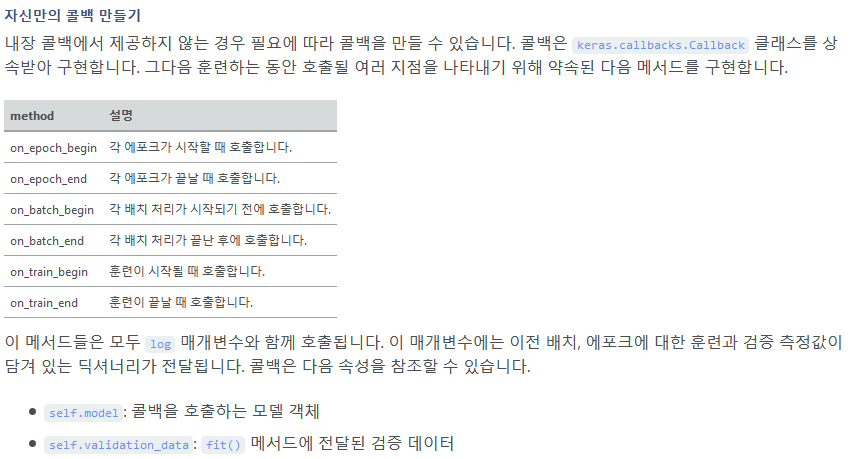

In [27]:
### 모델 학습
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.compile(loss='mse', optimizer='Adam')


hist = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=50, batch_size=100, callbacks=callback_list)
#hist = model.fit(x_train_dict, y_train, validation_data=(x_valid_dict, y_valid), epochs=20, batch_size=100)

W1114 10:23:47.581875 11360 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1114 10:23:47.936764 11360 deprecation.py:323] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1114 10:23:49.340314 11360 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 3256 samples, validate on 389 samples
Epoch 1/50
3256/3256 [==============================] - 16s 5ms/step - loss: 0.0115 - val_loss: 0.0054
Epoch 2/50
3256/3256 [==============================] - 1s 434us/step - loss: 0.0091 - val_loss: 0.0041
Epoch 3/50
3256/3256 [==============================] - 1s 440us/step - loss: 0.0089 - val_loss: 0.0037
Epoch 4/50
3256/3256 [==============================] - 1s 439us/step - loss: 0.0087 - val_loss: 0.0037
Epoch 5/50
3256/3256 [==============================] - 1s 433us/step - loss: 0.0084 - val_loss: 0.0035
Epoch 6/50
3256/3256 [==============================] - 1s 441us/step - loss: 0.0083 - val_loss: 0.0034
Epoch 7/50
3256/3256 [==============================] - 1s 433us/step - loss: 0.0079 - val_loss: 0.0036
Epoch 8/50
3256/3256 [==============================] - 1s 438us/step - loss: 0.0076 - val_loss: 0.0032
Epoch 9/50
3256/3256 [==============================] - 1s 436us/step - loss: 0.0070 - val_loss: 0.0032
Epoch 10/50
3256/3

In [12]:
## 모델 저장
model.save('model/pm_prediction_model_achi_new.h5')

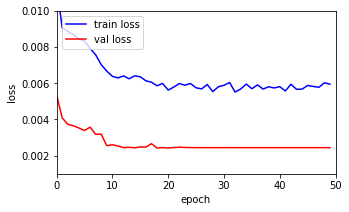

In [30]:
## 손실함수 변화 측정
fig = plt.figure(facecolor='white', figsize=(5, 3))
loss_ax = fig.add_subplot(111)

loss_ax.plot(hist.history['loss'], 'b', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.1, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.xlim([0, 50])
plt.ylim([0.001, 0.01])

plt.show()

In [32]:
## 결과 실제화
y_true = pm_seoul_data[test_cut:]

pred = model.predict(x_test)

y_pred = pred * pm_target

D:\_setup\anaconda3\envs\py3.7\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


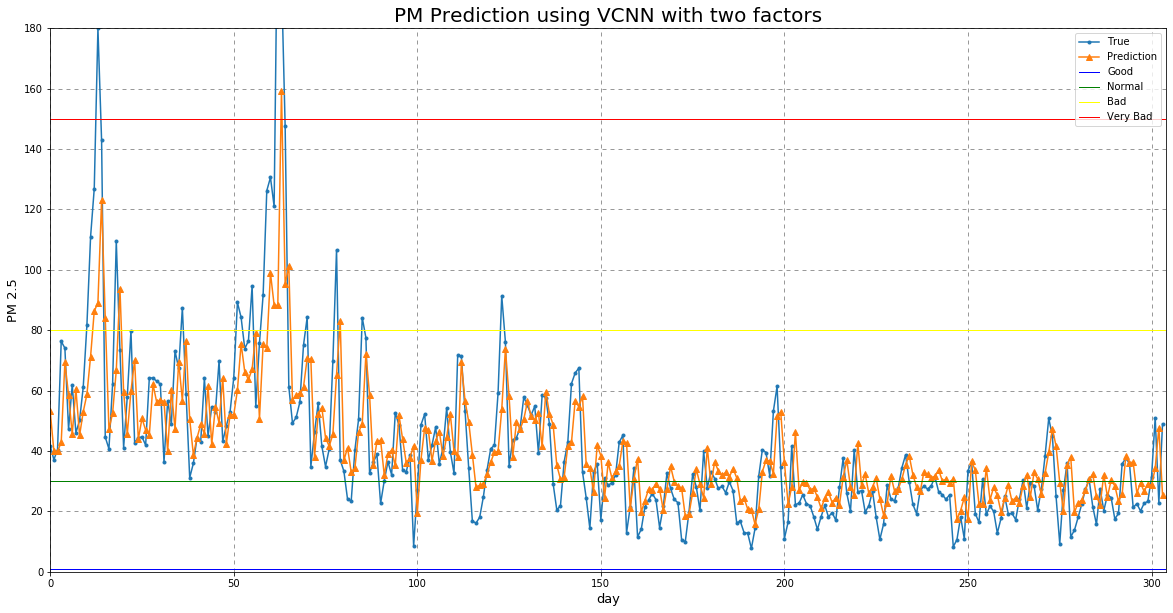

In [42]:
fig = plt.figure(facecolor='white', figsize=(20, 10))

plt.title('PM Prediction using LCNN with two factors', fontsize=20)

ax = fig.add_subplot(111)
ax.plot(y_true, label='True', marker='.')
ax.plot(y_pred, label='Prediction', marker='^')

plt.grid(color='gray', dashes=(5,5))

plt.axhline(y=1, color='blue', linewidth=1, label='Good')
plt.axhline(y=level_1, color='green', linewidth=1, label='Normal')
plt.axhline(y=level_2, color='yellow', linewidth=1, label='Bad')
plt.axhline(y=level_3, color='red', linewidth=1, label='Very Bad')

plt.xlabel('day', fontsize=13)
plt.ylabel('PM 2.5', fontsize=13)

plt.xlim([0, test_date])
plt.ylim([0, 180])

ax.legend()
plt.show()

In [34]:
## 단계별 정확도 및 총 정확도 계산 함수
def pm_level(pm):
    
    level_temp = []
    
    for i in range(len(pm)):
        if pm[i] <= level_1:
            level_temp.append(1)
        elif pm[i] <= level_2:
            level_temp.append(2)
        elif pm[i] <= level_3:
            level_temp.append(3)
        else:
            level_temp.append(4)
            
    return level_temp
    

In [35]:
def error_check(true, pred):
    y_true_lv = pm_level(true)
    y_pred_lv = pm_level(pred)
    
    level_1_acc = 0
    level_2_acc = 0
    level_3_acc = 0
    level_4_acc = 0

    level_1_count = y_true_lv.count(1)
    level_2_count = y_true_lv.count(2)
    level_3_count = y_true_lv.count(3)
    level_4_count = y_true_lv.count(4)
            
    
    error_rate_temp = []
    
    for i in range(len(y_pred_lv)):
        if y_pred_lv[i] == y_true_lv[i]:
            error_rate_temp.append(1)
            
            if y_pred_lv[i] == 1:
                level_1_acc += 1
            elif y_pred_lv[i] == 2:
                level_2_acc += 1
            elif y_pred_lv[i] == 3:
                level_3_acc += 1
            else:
                level_4_acc += 1
                    
        else:
            error_rate_temp.append(0)
    
    total_acc = sum(error_rate_temp) / len(error_rate_temp)
    
    
    level_1_accuracy = float(level_1_acc / level_1_count)
    level_2_accuracy = float(level_2_acc / level_2_count)
    level_3_accuracy = float(level_3_acc / level_3_count)
    level_4_accuracy = float(level_4_acc / level_4_count)
    
    level_accuracy = [level_1_accuracy,level_2_accuracy, level_3_accuracy, level_4_accuracy]
    
    return total_acc, level_accuracy


In [36]:
## 정확도 결과
total_acc, level_acc = error_check(y_true, y_pred)
print("total accuracy:", total_acc)
print("level 'Good' accuracy:", level_acc[0])
print("level 'Normal' accuracy:", level_acc[1])
print("level 'Bad' accuracy:", level_acc[2])
print("level 'Veray Bad' accuracy:", level_acc[3])

total accuracy: 0.7171052631578947
level 'Good' accuracy: 0.6
level 'Normal' accuracy: 0.8758169934640523
level 'Bad' accuracy: 0.2777777777777778
level 'Veray Bad' accuracy: 0.3333333333333333
